# Azure AI Foundry Agent Evaluators (Preview)

This notebook demonstrates how to use Azure AI Foundry's agent-specific evaluators to assess the performance of AI agents. We'll cover three main evaluators:

- **Intent Resolution**: Measures how well the system identifies and understands user requests
- **Tool Call Accuracy**: Evaluates the accuracy and efficiency of tool calls made by an agent
- **Task Adherence**: Assesses how well an agent adheres to assigned tasks

## Prerequisites

- Azure AI Foundry subscription
- Azure OpenAI resource
- Required Python packages: `azure-ai-evaluation`, `python-dotenv`

**Note**: Agent evaluators are currently in public preview.

## 1. Setup and Authentication

First, let's set up our environment variables and authentication. Create a `.env` file with your Azure credentials:

## 2. Import Required Libraries

Import all necessary libraries for agent evaluation:

In [ ]:
import os

from dotenv import load_dotenv

# Azure Identity for Entra ID authentication
from azure.identity import DefaultAzureCredential, AzureCliCredential

# Azure AI Evaluation imports
from azure.ai.evaluation import (
    AzureOpenAIModelConfiguration,
    IntentResolutionEvaluator,
    ToolCallAccuracyEvaluator,
    TaskAdherenceEvaluator, BleuScoreEvaluator
)

# Load environment variables (override any existing ones)
load_dotenv(override=True)

print(" Libraries imported ✅ successfully")

 Libraries imported ✅ successfully


## 3. Configure Azure AI Foundry Client

Set up the model configuration for the LLM-judge used by evaluators.

### Authentication Limitations & Workaround 

**Important**: The current version of `azure.ai.evaluation` library only supports **API key authentication**. However, some Azure OpenAI resources are configured to only allow Entra ID authentication (key-based authentication disabled).

### Workaround for Entra ID-Only Resources

If your Azure OpenAI resource has API key authentication disabled, we'll use a workaround:

1. **Get Entra ID Access Token**: Use Azure CLI to get an access token
2. **Token as API Key**: Pass the access token as the `api_key` parameter
3. **Automatic Fallback**: The code will automatically detect and use this approach

### Required Setup

Make sure you have:
1. **Azure CLI installed** and logged in (`az login`)
2. **Appropriate permissions** (Cognitive Services OpenAI User role)
3. **Environment variables** set in your `.env` file

### Environment Variables

```
AZURE_OPENAI_ENDPOINT=https://your-resource.openai.azure.com/
AZURE_OPENAI_DEPLOYMENT_NAME=your-deployment-name
OPENAI_API_VERSION=2024-10-21

# Optional: API key (if resource supports key-based auth)
AZURE_OPENAI_API_KEY=your-api-key-here
```

### Future Support

Microsoft is working on adding native Entra ID support to the Azure AI Evaluation library. Until then, this workaround provides a secure way to use Entra ID authentication.

In [10]:
# Configure Azure OpenAI model for evaluation
print(" Setting up authentication...")

# Note: The current version of azure.ai.evaluation AzureOpenAIModelConfiguration 
# only supports API key authentication, not azure_credential/Entra ID
# However, this resource has key-based authentication disabled.
# We'll use a workaround with Entra ID token

try:
    # First, try API key authentication if available
    if "AZURE_OPENAI_API_KEY" in os.environ and os.environ["AZURE_OPENAI_API_KEY"]:
        model_config = AzureOpenAIModelConfiguration(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
            api_version=os.environ["OPENAI_API_VERSION"],
        )
        
        print(" Model configuration created with API key authentication")
        print("   Authentication: API Key")
        
    else:
        # Fallback: Get Entra ID token and use as API key (workaround)
        print(" API key not available, using Entra ID token workaround...")
        
        # Get access token using Azure CLI
        import subprocess
        result = subprocess.run([
            "az", "account", "get-access-token", 
            "--resource", "https://cognitiveservices.azure.com"
        ], capture_output=True, text=True, check=True)
        
        import json
        token_info = json.loads(result.stdout)
        access_token = token_info["accessToken"]
        
        # Use token as API key (this is a workaround)
        model_config = AzureOpenAIModelConfiguration(
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            api_key=access_token,  # Use Entra ID token as API key
            azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
            api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        )
        
        print(" Model configuration created with Entra ID token (workaround)")
        print("   Authentication: Entra ID Token (as API Key)")
        print("   Note: This is a workaround for the library limitation")
        
except KeyError as e:
    print(f" Missing environment variable: {e}")
    print("   Please ensure all required environment variables are set:")
    print("   - AZURE_OPENAI_ENDPOINT")
    print("   - AZURE_OPENAI_DEPLOYMENT_NAME")
    print("   - OPENAI_API_VERSION")
    raise
except Exception as e:
    print(f" ❌ Error setting up authentication: {e}")
    print("   Make sure you're logged in with 'az login' and have appropriate permissions")
    raise

print(f"   Endpoint: {os.environ['AZURE_OPENAI_ENDPOINT']}")
print(f"   Deployment: {os.environ['AZURE_OPENAI_DEPLOYMENT_NAME']}")
print(f"   API Version: {os.environ['AZURE_OPENAI_API_VERSION']}")

 Setting up authentication...
 API key not available, using Entra ID token workaround...
 Model configuration created with Entra ID token (workaround)
   Authentication: Entra ID Token (as API Key)
   Note: This is a workaround for the library limitation
   Endpoint: https://foundry-fr8lmydf.cognitiveservices.azure.com/
   Deployment: gpt-4.1-mini
   API Version: 2024-10-21


## 4. Intent Resolution Evaluator

The `IntentResolutionEvaluator` measures how well the system identifies and understands a user's request. It evaluates:
- How well it scopes the user's intent
- How well it asks clarifying questions
- How well it reminds users of its capabilities

**Score**: 1-5 (Likert scale), higher is better

In [11]:
# Initialize Intent Resolution evaluator
intent_resolution = IntentResolutionEvaluator(
    model_config=model_config, 
    threshold=3  # Scores >= 3 are considered "pass"
)

print(" Intent Resolution Evaluator initialized")

 Intent Resolution Evaluator initialized


### Example 1: ✅ Good Intent Resolution

In [12]:
import json

# Example of good intent resolution
result_good = intent_resolution(
    query="What are the opening hours of the Eiffel Tower?",
    response="The Eiffel Tower is open daily from 9:00 AM to 11:00 PM. Please note that hours may vary during holidays or special events."
)

print("=== Good Intent Resolution Example ===")
print(f"Query: What are the opening hours of the Eiffel Tower?")
print(f"Response: The Eiffel Tower is open daily from 9:00 AM to 11:00 PM...")
print("\n--- Evaluation Results ---")
print(f"Score: ✅ {result_good['intent_resolution']}")
print(f"Result: ✅ {result_good['intent_resolution_result']}")
print(f"Reason: ✅ {result_good['intent_resolution_reason']}")

# Check if additional_details exists before accessing it
if 'additional_details' in result_good:
    print(f"Additional Details: ✅ {json.dumps(result_good['additional_details'], indent=2)}")
else:
    print("Additional Details: Not available")
    print(f"Available keys in result: ✅ {list(result_good.keys())}")

Conversation history could not be parsed, falling back to original query: What are the opening hours of the Eiffel Tower?
Empty agent response extracted, likely due to input schema change. Falling back to using the original response: The Eiffel Tower is open daily from 9:00 AM to 11:00 PM. Please note that hours may vary during holidays or special events.


=== Good Intent Resolution Example ===
Query: What are the opening hours of the Eiffel Tower?
Response: The Eiffel Tower is open daily from 9:00 AM to 11:00 PM...

--- Evaluation Results ---
Score: ✅ 5.0
Result: ✅ pass
Reason: ✅ User asked for the Eiffel Tower's opening hours. The agent provided clear, accurate daily hours and a helpful note about possible holiday variations, fully satisfying the user's intent with relevant and complete information.
Additional Details: Not available
Available keys in result: ✅ ['intent_resolution', 'intent_resolution_result', 'intent_resolution_threshold', 'intent_resolution_reason']


### Example 2: Poor Intent Resolution

In [13]:
import json

# Example of poor intent resolution
result_poor = intent_resolution(
    query="What are the opening hours of the Eiffel Tower?",
    response="Paris is a beautiful city with many attractions to visit."
)

print("=== Poor Intent Resolution Example ===")
print(f"Query: What are the opening hours of the Eiffel Tower?")
print(f"Response: Paris is a beautiful city with many attractions to visit.")
print("\n--- Evaluation Results ---")
print(f"Score: {result_poor['intent_resolution']}")
print(f"Result: {result_poor['intent_resolution_result']}")
print(f"Reason: {result_poor['intent_resolution_reason']}")

# Check if additional_details exists before accessing it
if 'additional_details' in result_poor:
    print(f"Additional Details: {json.dumps(result_poor['additional_details'], indent=2)}")
else:
    print("Additional Details: Not available")
    print(f"Available keys in result: {list(result_poor.keys())}")

Conversation history could not be parsed, falling back to original query: What are the opening hours of the Eiffel Tower?
Empty agent response extracted, likely due to input schema change. Falling back to using the original response: Paris is a beautiful city with many attractions to visit.


=== Poor Intent Resolution Example ===
Query: What are the opening hours of the Eiffel Tower?
Response: Paris is a beautiful city with many attractions to visit.

--- Evaluation Results ---
Score: 1.0
Result: fail
Reason: User asked for the opening hours of the Eiffel Tower, but the agent responded with a generic comment about Paris attractions, providing no relevant information about the requested hours. The intent was completely ignored.
Additional Details: Not available
Available keys in result: ['intent_resolution', 'intent_resolution_result', 'intent_resolution_threshold', 'intent_resolution_reason']


## 5. Tool Call Accuracy Evaluator

The `ToolCallAccuracyEvaluator` measures the accuracy and efficiency of tool calls made by an agent. It evaluates:
- Relevance and helpfulness of the tool invoked
- Correctness of parameters used in tool calls
- Counts of missing or excessive calls

**Note**: Only supports Azure AI Agent's Function Tool evaluation (not Built-in Tools)
**Score**: 1-5 (Likert scale), higher is better

In [14]:
# Initialize Tool Call Accuracy evaluator
tool_call_accuracy = ToolCallAccuracyEvaluator(
    model_config=model_config, 
    threshold=3
)

print(" Tool Call Accuracy Evaluator initialized")

 Tool Call Accuracy Evaluator initialized


### Example: Weather Query Tool Call

In [15]:
# Example tool call evaluation
tool_result = tool_call_accuracy(
    query="How is the weather in Seattle?",
    tool_calls=[
        {
            "type": "tool_call",
            "tool_call_id": "call_CUdbkBfvVBla2YP3p24uhElJ",
            "name": "fetch_weather",
            "arguments": {
                "location": "Seattle"
            }
        }
    ],
    tool_definitions=[
        {
            "id": "fetch_weather",
            "name": "fetch_weather",
            "description": "Fetches the weather information for the specified location.",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The location to fetch weather for."
                    }
                }
            }
        }
    ]
)

print("=== Tool Call Accuracy Example ===")
print(f"Query: How is the weather in Seattle?")
print(f"Tool Called: fetch_weather(location='Seattle')")
print("\n--- Evaluation Results ---")
print(f"Score: {tool_result['tool_call_accuracy']}")
print(f"Result: {tool_result['tool_call_accuracy_result']}")
print(f"Details: {json.dumps(tool_result['details'], indent=2)}")

=== Tool Call Accuracy Example ===
Query: How is the weather in Seattle?
Tool Called: fetch_weather(location='Seattle')

--- Evaluation Results ---
Score: 5.0
Result: pass
Details: {
  "tool_calls_made_by_agent": 1,
  "correct_tool_calls_made_by_agent": 1,
  "per_tool_call_details": [
    {
      "tool_name": "fetch_weather",
      "total_calls_required": 1,
      "correct_calls_made_by_agent": 1,
      "correct_tool_percentage": 1.0,
      "tool_call_errors": 0,
      "tool_success_result": "pass"
    }
  ],
  "excess_tool_calls": {
    "total": 0,
    "details": []
  },
  "missing_tool_calls": {
    "total": 0,
    "details": []
  }
}


### Example: Multiple Tool Calls

In [16]:
# Example with multiple tool calls
multi_tool_result = tool_call_accuracy(
    query="What's the weather in New York and what restaurants are nearby?",
    tool_calls=[
        {
            "type": "tool_call",
            "tool_call_id": "call_weather_001",
            "name": "fetch_weather",
            "arguments": {
                "location": "New York"
            }
        },
        {
            "type": "tool_call",
            "tool_call_id": "call_restaurants_001",
            "name": "find_restaurants",
            "arguments": {
                "location": "New York",
                "radius": "5km"
            }
        }
    ],
    tool_definitions=[
        {
            "id": "fetch_weather",
            "name": "fetch_weather",
            "description": "Fetches the weather information for the specified location.",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The location to fetch weather for."
                    }
                }
            }
        },
        {
            "id": "find_restaurants",
            "name": "find_restaurants",
            "description": "Find restaurants near a specified location.",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The location to search near."
                    },
                    "radius": {
                        "type": "string",
                        "description": "Search radius (e.g., '5km', '1mile')."
                    }
                }
            }
        }
    ]
)

print("=== Multiple Tool Calls Example ===")
print(f"Query: What's the weather in New York and what restaurants are nearby?")
print(f"Tools Called: fetch_weather + find_restaurants")
print("\n--- Evaluation Results ---")
print(f"Score: {multi_tool_result['tool_call_accuracy']}")
print(f"Result: {multi_tool_result['tool_call_accuracy_result']}")
print(f"Total Tools Called: {multi_tool_result['details']['tool_calls_made_by_agent']}")
print(f"Correct Tools Called: {multi_tool_result['details']['correct_tool_calls_made_by_agent']}")

=== Multiple Tool Calls Example ===
Query: What's the weather in New York and what restaurants are nearby?
Tools Called: fetch_weather + find_restaurants

--- Evaluation Results ---
Score: 5.0
Result: pass
Total Tools Called: 2
Correct Tools Called: 2


## 6. Task Adherence Evaluator

The `TaskAdherenceEvaluator` measures how well an agent's response adheres to their assigned tasks. It evaluates:
- Adherence to task instructions (from system message and user query)
- Appropriate use of available tools
- Staying on track vs. making inefficient or out-of-scope steps

**Score**: 1-5 (Likert scale), higher is better

In [17]:
# Initialize Task Adherence evaluator
task_adherence = TaskAdherenceEvaluator(
    model_config=model_config, 
    threshold=3
)

print(" Task Adherence Evaluator initialized")

Class TaskAdherenceEvaluator: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


 Task Adherence Evaluator initialized


### Example 1: ✅ Good Task Adherence

In [18]:
# Example of good task adherence
adherence_good = task_adherence(
    query="What are the best practices for maintaining a healthy rose garden during the summer?",
    response="""Here are the key best practices for maintaining a healthy rose garden during summer:

1. **Watering**: Water deeply 2-3 times per week, preferably early morning. Aim for 1-1.5 inches per week.
2. **Mulching**: Apply 2-3 inches of organic mulch around plants to retain moisture and suppress weeds.
3. **Pruning**: Remove spent blooms (deadheading) regularly and prune any diseased or damaged canes.
4. **Fertilizing**: Apply balanced fertilizer monthly during growing season.
5. **Disease Prevention**: Ensure good air circulation and avoid overhead watering to prevent fungal diseases.
6. **Pest Management**: Monitor for aphids, spider mites, and thrips. Use integrated pest management approaches.
7. **Heat Protection**: Consider shade cloth during extreme heat waves (above 90°F).

Regular monitoring and consistent care are key to healthy roses in summer heat."""
)

print("=== Good Task Adherence Example ===")
print(f"Query: What are the best practices for maintaining a healthy rose garden during the summer?")
print(f"Response: [Detailed rose care instructions...]")
print("\n--- Evaluation Results ---")
print(f"Score: ✅ {adherence_good['task_adherence']}")
print(f"Result: ✅ {adherence_good['task_adherence_result']}")
print(f"Reason: ✅ {adherence_good['task_adherence_reason']}")

Conversation history could not be parsed, falling back to original query: What are the best practices for maintaining a healthy rose garden during the summer?
Agent response could not be parsed, falling back to original response: Here are the key best practices for maintaining a healthy rose garden during summer:

1. **Watering**: Water deeply 2-3 times per week, preferably early morning. Aim for 1-1.5 inches per week.
2. **Mulching**: Apply 2-3 inches of organic mulch around plants to retain moisture and suppress weeds.
3. **Pruning**: Remove spent blooms (deadheading) regularly and prune any diseased or damaged canes.
4. **Fertilizing**: Apply balanced fertilizer monthly during growing season.
5. **Disease Prevention**: Ensure good air circulation and avoid overhead watering to prevent fungal diseases.
6. **Pest Management**: Monitor for aphids, spider mites, and thrips. Use integrated pest management approaches.
7. **Heat Protection**: Consider shade cloth during extreme heat waves 

=== Good Task Adherence Example ===
Query: What are the best practices for maintaining a healthy rose garden during the summer?
Response: [Detailed rose care instructions...]

--- Evaluation Results ---
Score: ✅ 5.0
Result: ✅ pass
Reason: ✅ The assistant fully addressed the user's request by listing comprehensive best practices for summer rose garden care. There were no system constraints or tool requirements, and the response was clear, detailed, and relevant, satisfying the user's need completely.


### Example 2: Poor Task Adherence

In [19]:
# Example of poor task adherence
adherence_poor = task_adherence(
    query="What are the best practices for maintaining a healthy rose garden during the summer?",
    response="Make sure to water your roses regularly and trim them occasionally."
)

print("=== Poor Task Adherence Example ===")
print(f"Query: What are the best practices for maintaining a healthy rose garden during the summer?")
print(f"Response: Make sure to water your roses regularly and trim them occasionally.")
print("\n--- Evaluation Results ---")
print(f"Score: {adherence_poor['task_adherence']}")
print(f"Result: {adherence_poor['task_adherence_result']}")
print(f"Reason: {adherence_poor['task_adherence_reason']}")

Conversation history could not be parsed, falling back to original query: What are the best practices for maintaining a healthy rose garden during the summer?
Agent response could not be parsed, falling back to original response: Make sure to water your roses regularly and trim them occasionally.


=== Poor Task Adherence Example ===
Query: What are the best practices for maintaining a healthy rose garden during the summer?
Response: Make sure to water your roses regularly and trim them occasionally.

--- Evaluation Results ---
Score: 3.0
Result: pass
Reason: The assistant provided a brief answer addressing watering and trimming roses but missed other key summer care practices like pest control, fertilizing, and sun protection. No system constraints or tools were specified, so the response is minimally adequate but incomplete.


## 7. Batch Evaluation of Agent Responses

Let's evaluate multiple scenarios in batch to get a comprehensive view of agent performance:

In [20]:
# Define test scenarios
test_scenarios = [
    {
        "id": 1,
        "query": "What time does the library close on Sundays?",
        "response": "The library closes at 6:00 PM on Sundays. Please note that hours may change during holidays.",
        "category": "Information Request"
    },
    {
        "id": 2,
        "query": "Can you help me book a flight to Tokyo?",
        "response": "I can't directly book flights, but I can help you find flight options and guide you to booking websites. Would you like me to search for flights to Tokyo?",
        "category": "Service Limitation"
    },
    {
        "id": 3,
        "query": "How do I reset my password?",
        "response": "The weather is nice today, isn't it?",
        "category": "Irrelevant Response"
    },
    {
        "id": 4,
        "query": "Explain quantum computing in simple terms",
        "response": "Quantum computing uses quantum mechanics principles like superposition and entanglement to process information. Unlike classical bits that are either 0 or 1, quantum bits (qubits) can be in multiple states simultaneously, potentially allowing for much faster computation of certain problems.",
        "category": "Educational Content"
    }
]

print(f" Defined {len(test_scenarios)} test scenarios for batch evaluation")

 Defined 4 test scenarios for batch evaluation


In [21]:
# Batch evaluation with Intent Resolution
batch_results = []

print(" Running batch evaluation with Intent Resolution Evaluator...\n")

for i, scenario in enumerate(test_scenarios):
    print(f"Processing scenario {scenario['id']}/{len(test_scenarios)} ({scenario['category']})...")
    
    try:
        # Evaluate the scenario
        result = intent_resolution(
            query=scenario["query"],
            response=scenario["response"]
        )
        
        # Safely extract intent_resolved, defaulting to False if not available
        intent_resolved = False
        if 'additional_details' in result and 'intent_resolved' in result['additional_details']:
            intent_resolved = result['additional_details']['intent_resolved']
        elif result.get('intent_resolution_result') == 'pass':
            intent_resolved = True  # Assume intent was resolved if evaluation passed
            
        batch_results.append({
            "id": scenario["id"],
            "category": scenario["category"],
            "query": scenario["query"],
            "response": scenario["response"],
            "intent_resolution_score": result["intent_resolution"],
            "intent_resolution_result": result["intent_resolution_result"],
            "intent_resolved": intent_resolved
        })
        
        print(f"   Score: {result['intent_resolution']} | Result: {result['intent_resolution_result']}")
        print(f"  Intent Resolved: {intent_resolved}")
        
    except Exception as e:
        print(f"   ❌ Error evaluating scenario {scenario['id']}: {str(e)}")
        # Add placeholder result for ❌ failed evaluation
        batch_results.append({
            "id": scenario["id"],
            "category": scenario["category"],
            "query": scenario["query"],
            "response": scenario["response"],
            "intent_resolution_score": None,
            "intent_resolution_result": "error",
            "intent_resolved": False
        })
    
    print()

successful_evaluations = len([r for r in batch_results if r["intent_resolution_score"] is not None])
print(f" Batch evaluation completed: ✅ {successful_evaluations}/{len(test_scenarios)} successful evaluations")

Conversation history could not be parsed, falling back to original query: What time does the library close on Sundays?
Empty agent response extracted, likely due to input schema change. Falling back to using the original response: The library closes at 6:00 PM on Sundays. Please note that hours may change during holidays.


 Running batch evaluation with Intent Resolution Evaluator...

Processing scenario 1/4 (Information Request)...


Conversation history could not be parsed, falling back to original query: Can you help me book a flight to Tokyo?
Empty agent response extracted, likely due to input schema change. Falling back to using the original response: I can't directly book flights, but I can help you find flight options and guide you to booking websites. Would you like me to search for flights to Tokyo?


   Score: 5.0 | Result: pass
  Intent Resolved: True

Processing scenario 2/4 (Service Limitation)...


Conversation history could not be parsed, falling back to original query: How do I reset my password?
Empty agent response extracted, likely due to input schema change. Falling back to using the original response: The weather is nice today, isn't it?


   Score: 5.0 | Result: pass
  Intent Resolved: True

Processing scenario 3/4 (Irrelevant Response)...


Conversation history could not be parsed, falling back to original query: Explain quantum computing in simple terms
Empty agent response extracted, likely due to input schema change. Falling back to using the original response: Quantum computing uses quantum mechanics principles like superposition and entanglement to process information. Unlike classical bits that are either 0 or 1, quantum bits (qubits) can be in multiple states simultaneously, potentially allowing for much faster computation of certain problems.


   Score: 1.0 | Result: fail
  Intent Resolved: False

Processing scenario 4/4 (Educational Content)...
   Score: 5.0 | Result: pass
  Intent Resolved: True

 Batch evaluation completed: ✅ 4/4 successful evaluations


## 8. Performance Metrics Analysis

Let's analyze the batch evaluation results to understand overall agent performance:

In [22]:
import pandas as pd
import numpy as np

# Convert results to DataFrame for analysis
df_results = pd.DataFrame(batch_results)

if not df_results.empty:
    # Filter out ❌ failed evaluations for accurate statistics
    df_successful = df_results[df_results['intent_resolution_score'].notna()]
    
    if not df_successful.empty:
        # Calculate summary statistics
        avg_score = df_successful['intent_resolution_score'].mean()
        pass_rate = (df_successful['intent_resolution_result'] == 'pass').mean() * 100
        intent_resolution_rate = df_successful['intent_resolved'].mean() * 100
        success_rate = len(df_successful) / len(df_results) * 100
        
        print("=== Performance Metrics Summary ===")
        print(f"Successful Evaluations: ✅ {len(df_successful)}/{len(df_results)} ({success_rate:.1f}%)")
        print(f"Average Intent Resolution Score: {avg_score:.2f} / 5.0")
        print(f"Pass Rate (Score >= 3): {pass_rate:.1f}%")
        print(f"Intent Resolution Rate: {intent_resolution_rate:.1f}%")
        print()
        
        # Performance by category (successful evaluations only)
        print("=== Performance by Category ===")
        category_stats = df_successful.groupby('category').agg({
            'intent_resolution_score': ['mean', 'count'],
            'intent_resolved': 'mean'
        }).round(2)
        
        print(category_stats)
        print()
        
        # Display detailed results
        print("=== Detailed Results ===")
        for _, row in df_results.iterrows():
            status = "" if row['intent_resolution_score'] is not None else ""
            print(f"{status} Scenario {row['id']}: {row['category']}")
            print(f"  Query: {row['query'][:60]}{'...' if len(row['query']) > 60 else ''}")
            if row['intent_resolution_score'] is not None:
                print(f"  Score: {row['intent_resolution_score']} | Result: {row['intent_resolution_result']}")
            else:
                print(f"  Status: ❌ {row['intent_resolution_result']} (evaluation ❌ failed)")
            print()
            
    else:
        print(" All evaluations ❌ failed.")
        print(" Check your Azure OpenAI deployment and authentication.")
else:
    print("No results to analyze. Please run the batch evaluation first.")

=== Performance Metrics Summary ===
Successful Evaluations: ✅ 4/4 (100.0%)
Average Intent Resolution Score: 4.00 / 5.0
Pass Rate (Score >= 3): 75.0%
Intent Resolution Rate: 75.0%

=== Performance by Category ===
                    intent_resolution_score       intent_resolved
                                       mean count            mean
category                                                         
Educational Content                     5.0     1             1.0
Information Request                     5.0     1             1.0
Irrelevant Response                     1.0     1             0.0
Service Limitation                      5.0     1             1.0

=== Detailed Results ===
 Scenario 1: Information Request
  Query: What time does the library close on Sundays?
  Score: 5.0 | Result: pass

 Scenario 2: Service Limitation
  Query: Can you help me book a flight to Tokyo?
  Score: 5.0 | Result: pass

 Scenario 3: Irrelevant Response
  Query: How do I reset my password?
  Sc

## 9. Working with Reasoning Models

For complex evaluations, Azure AI Foundry supports reasoning models (o-series) which can provide more refined evaluation. Here's how to configure them:

In [23]:
# Example configuration for reasoning models (o3-mini, etc.)
# Uncomment and modify if you have access to reasoning models

# reasoning_model_config = AzureOpenAIModelConfiguration(
#     azure_endpoint=os.environ["AZURE_ENDPOINT"],
#     api_key=os.environ["AZURE_API_KEY"],
#     azure_deployment=os.environ.get("AZURE_REASONING_DEPLOYMENT", "o3-mini"),
#     api_version=os.environ["AZURE_API_VERSION"],
# )

# # Initialize evaluators with reasoning model
# reasoning_intent_evaluator = IntentResolutionEvaluator(
#     model_config=reasoning_model_config,
#     is_reasoning_model=True,  # Important: Set this to True for reasoning models
#     threshold=3
# )

print(" Reasoning model configuration example provided (commented out)")
print("   Set is_reasoning_model=True when using o-series models")
print("   Reasoning models are recommended for complex evaluations requiring refined reasoning")

 Reasoning model configuration example provided (commented out)
   Set is_reasoning_model=True when using o-series models
   Reasoning models are recommended for complex evaluations requiring refined reasoning


## 10. Evaluation Results Visualization

Create visualizations to better understand evaluation results:

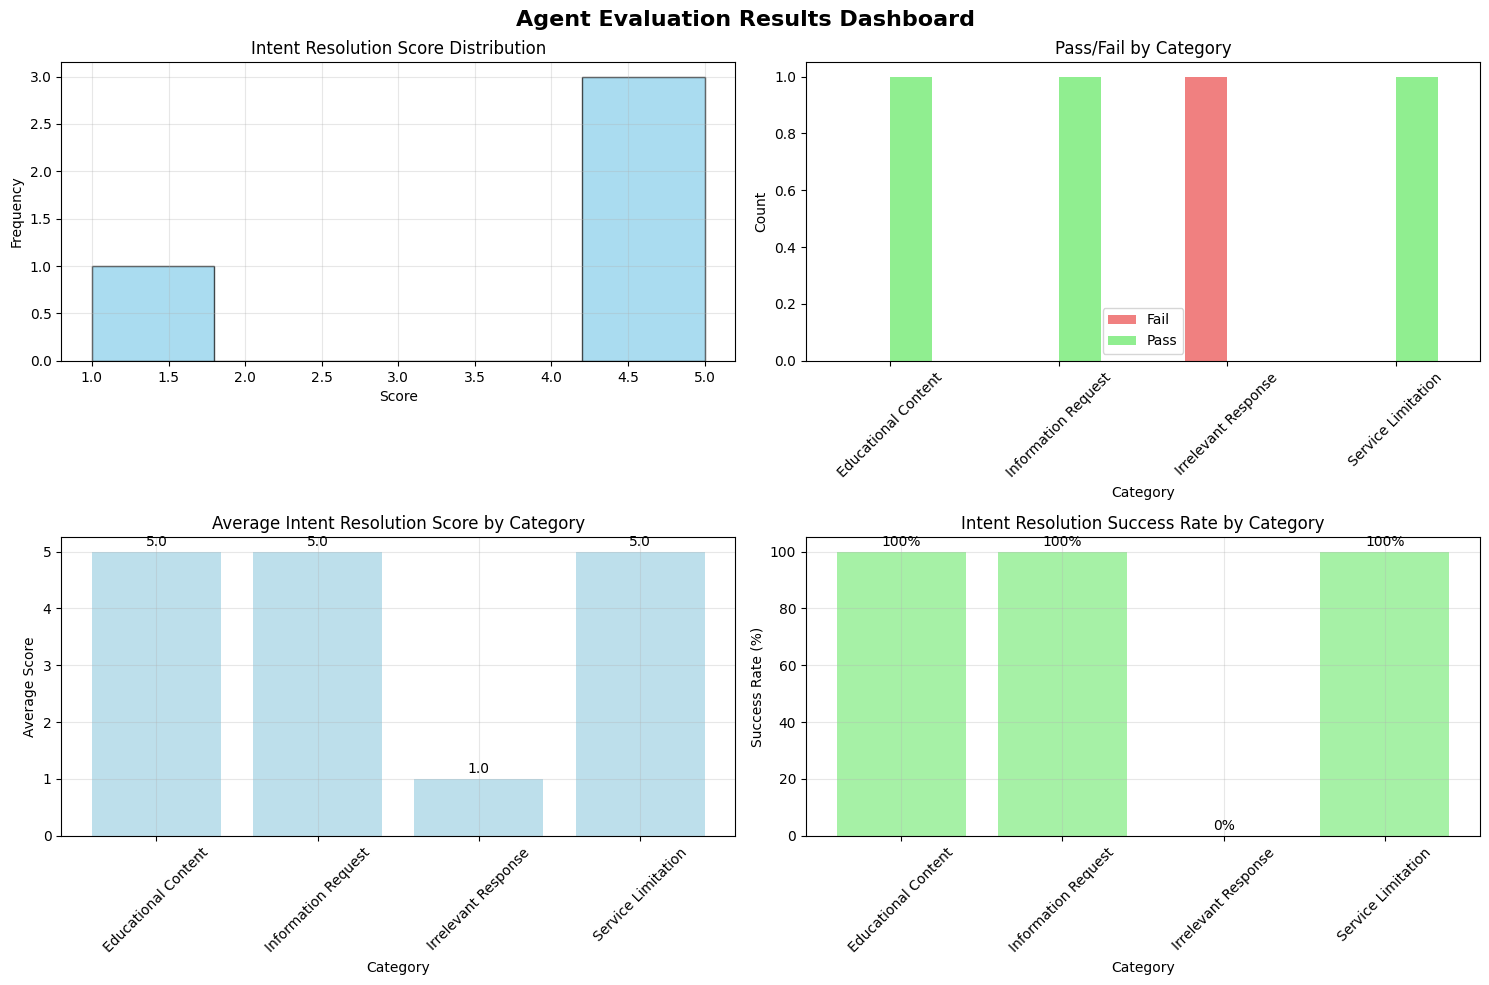

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

if not df_results.empty:
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Agent Evaluation Results Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Score distribution
    axes[0, 0].hist(df_results['intent_resolution_score'], bins=5, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Intent Resolution Score Distribution')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Pass/Fail by category
    category_counts = df_results.groupby(['category', 'intent_resolution_result']).size().unstack(fill_value=0)
    category_counts.plot(kind='bar', ax=axes[0, 1], color=['lightcoral', 'lightgreen'])
    axes[0, 1].set_title('Pass/Fail by Category')
    axes[0, 1].set_xlabel('Category')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(['Fail', 'Pass'])
    
    # 3. Average scores by category
    avg_scores = df_results.groupby('category')['intent_resolution_score'].mean()
    bars = axes[1, 0].bar(avg_scores.index, avg_scores.values, color='lightblue', alpha=0.8)
    axes[1, 0].set_title('Average Intent Resolution Score by Category')
    axes[1, 0].set_xlabel('Category')
    axes[1, 0].set_ylabel('Average Score')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                       f'{height:.1f}', ha='center', va='bottom')
    
    # 4. Intent resolution success rate
    intent_success = df_results.groupby('category')['intent_resolved'].mean() * 100
    bars2 = axes[1, 1].bar(intent_success.index, intent_success.values, color='lightgreen', alpha=0.8)
    axes[1, 1].set_title('Intent Resolution Success Rate by Category')
    axes[1, 1].set_xlabel('Category')
    axes[1, 1].set_ylabel('Success Rate (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add percentage labels
    for bar in bars2:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.0f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No data available for visualization. Please run the batch evaluation first.")

## Best Practices and Recommendations

### Evaluator Selection Guide

| Evaluator | Use Case | Score Range | Key Metrics |
|-----------|----------|-------------|-------------|
| **Intent Resolution** | Measure understanding of user requests | 1-5 | Intent detection, clarification, scope awareness |
| **Tool Call Accuracy** | Evaluate function/tool usage efficiency | 1-5 | Tool relevance, parameter correctness, call efficiency |
| **Task Adherence** | Assess adherence to assigned tasks | 1-5 | Task completion, scope adherence, efficiency |

### Model Recommendations

- **Reasoning Models** (o3-mini, o-series): Use for complex evaluations requiring refined reasoning
- **Standard Models** (GPT-4o, GPT-4.1): Use for general evaluation tasks
- Set `is_reasoning_model=True` when using o-series models

### Performance Optimization

1. **Threshold Setting**: Adjust thresholds based on your quality requirements (default: 3)
2. **Batch Processing**: Evaluate multiple scenarios for comprehensive assessment
3. **Category Analysis**: Group similar use cases for targeted improvements
4. **Continuous Monitoring**: Regularly evaluate agent performance in production

### Integration with Azure AI Agent Service

For agents built with Azure AI Agent Service, these evaluators provide native integration that directly takes agent messages. See the [end-to-end example](https://aka.ms/e2e-agent-eval-sample) for complete implementation.

## Summary

This notebook demonstrated how to use Azure AI Foundry's agent evaluators to assess AI agent performance:

 **Intent Resolution Evaluator**: Measures understanding of user requests  
 **Tool Call Accuracy Evaluator**: Evaluates function call efficiency and correctness  
 **Task Adherence Evaluator**: Assesses adherence to assigned tasks  
 **Batch Evaluation**: Process multiple scenarios for comprehensive assessment  
 **Performance Analysis**: Calculate metrics and identify improvement areas  
 **Visualization**: Create charts to understand evaluation results  

### Next Steps

1. **Customize Evaluators**: Adjust thresholds and parameters for your specific use case
2. **Expand Test Scenarios**: Create more comprehensive test suites
3. **Integrate with CI/CD**: Automate evaluation in your development pipeline
4. **Monitor Production**: Set up continuous evaluation for deployed agents
5. **Explore Additional Evaluators**: Try other quality and safety evaluators available in Azure AI Foundry

For more information, visit the [Azure AI Foundry documentation](https://learn.microsoft.com/en-us/azure/ai-foundry/concepts/evaluation-evaluators/agent-evaluators).